In [1]:
! git clone https://github.com/ds4e/scratchpad
%run ./scratchpad/get_data.py

Cloning into 'scratchpad'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 37), reused 30 (delta 30), pack-reused 65 (from 2)
Receiving objects: 100% (109/109), 657.47 KiB | 13.42 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Download complete
Extracting data files...
Data extracted


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

mse = lambda y, y_hat: np.sum(( y-y_hat)**2 )/len(y)

df = pd.read_csv('./data/metabric.csv')
df.head()

,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Chemotherapy,Hormone Therapy,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Overall Survival Status,Radio Therapy,TMB (nonsynonymous),Tumor Size,Tumor Stage
0,43.19,BREAST CONSERVING,Breast Cancer,NO,YES,0.0,2.0,4.020,84.633333,0:LIVING,YES,2.615035,10.0,1.0
1,48.87,MASTECTOMY,Breast Cancer,YES,YES,1.0,2.0,4.030,163.700000,1:DECEASED,NO,2.615035,15.0,2.0
2,47.68,MASTECTOMY,Breast Cancer,YES,YES,3.0,1.0,4.050,164.933333,0:LIVING,YES,1.307518,25.0,2.0
3,76.97,MASTECTOMY,Breast Cancer,YES,YES,8.0,2.0,6.080,41.366667,1:DECEASED,YES,2.615035,40.0,2.0
4,78.77,MASTECTOMY,Breast Cancer,NO,YES,0.0,4.0,4.062,7.800000,1:DECEASED,YES,5.230071,31.0,4.0


,Overall Survival (Months)
count,1343.000000
mean,129.094291
std,78.290236
min,0.100000
25%,62.700000
50%,118.533333
75%,191.200000
max,351.000000


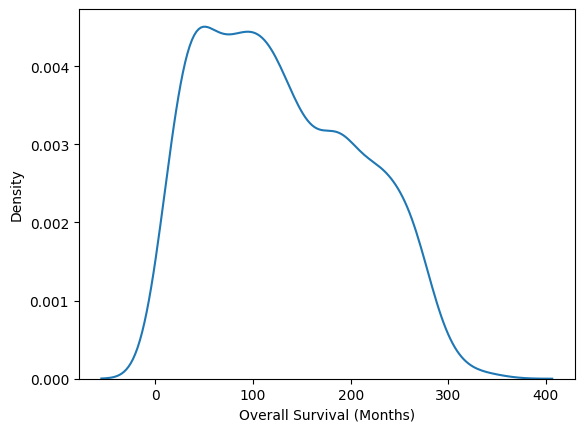

In [53]:
y = df['Overall Survival (Months)']
sns.kdeplot(y)
y.describe()

In [54]:
df.columns

Index(['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
       'Chemotherapy', 'Hormone Therapy', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index',
       'Overall Survival (Months)', 'Overall Survival Status', 'Radio Therapy',
       'TMB (nonsynonymous)', 'Tumor Size', 'Tumor Stage'],
      dtype='object')

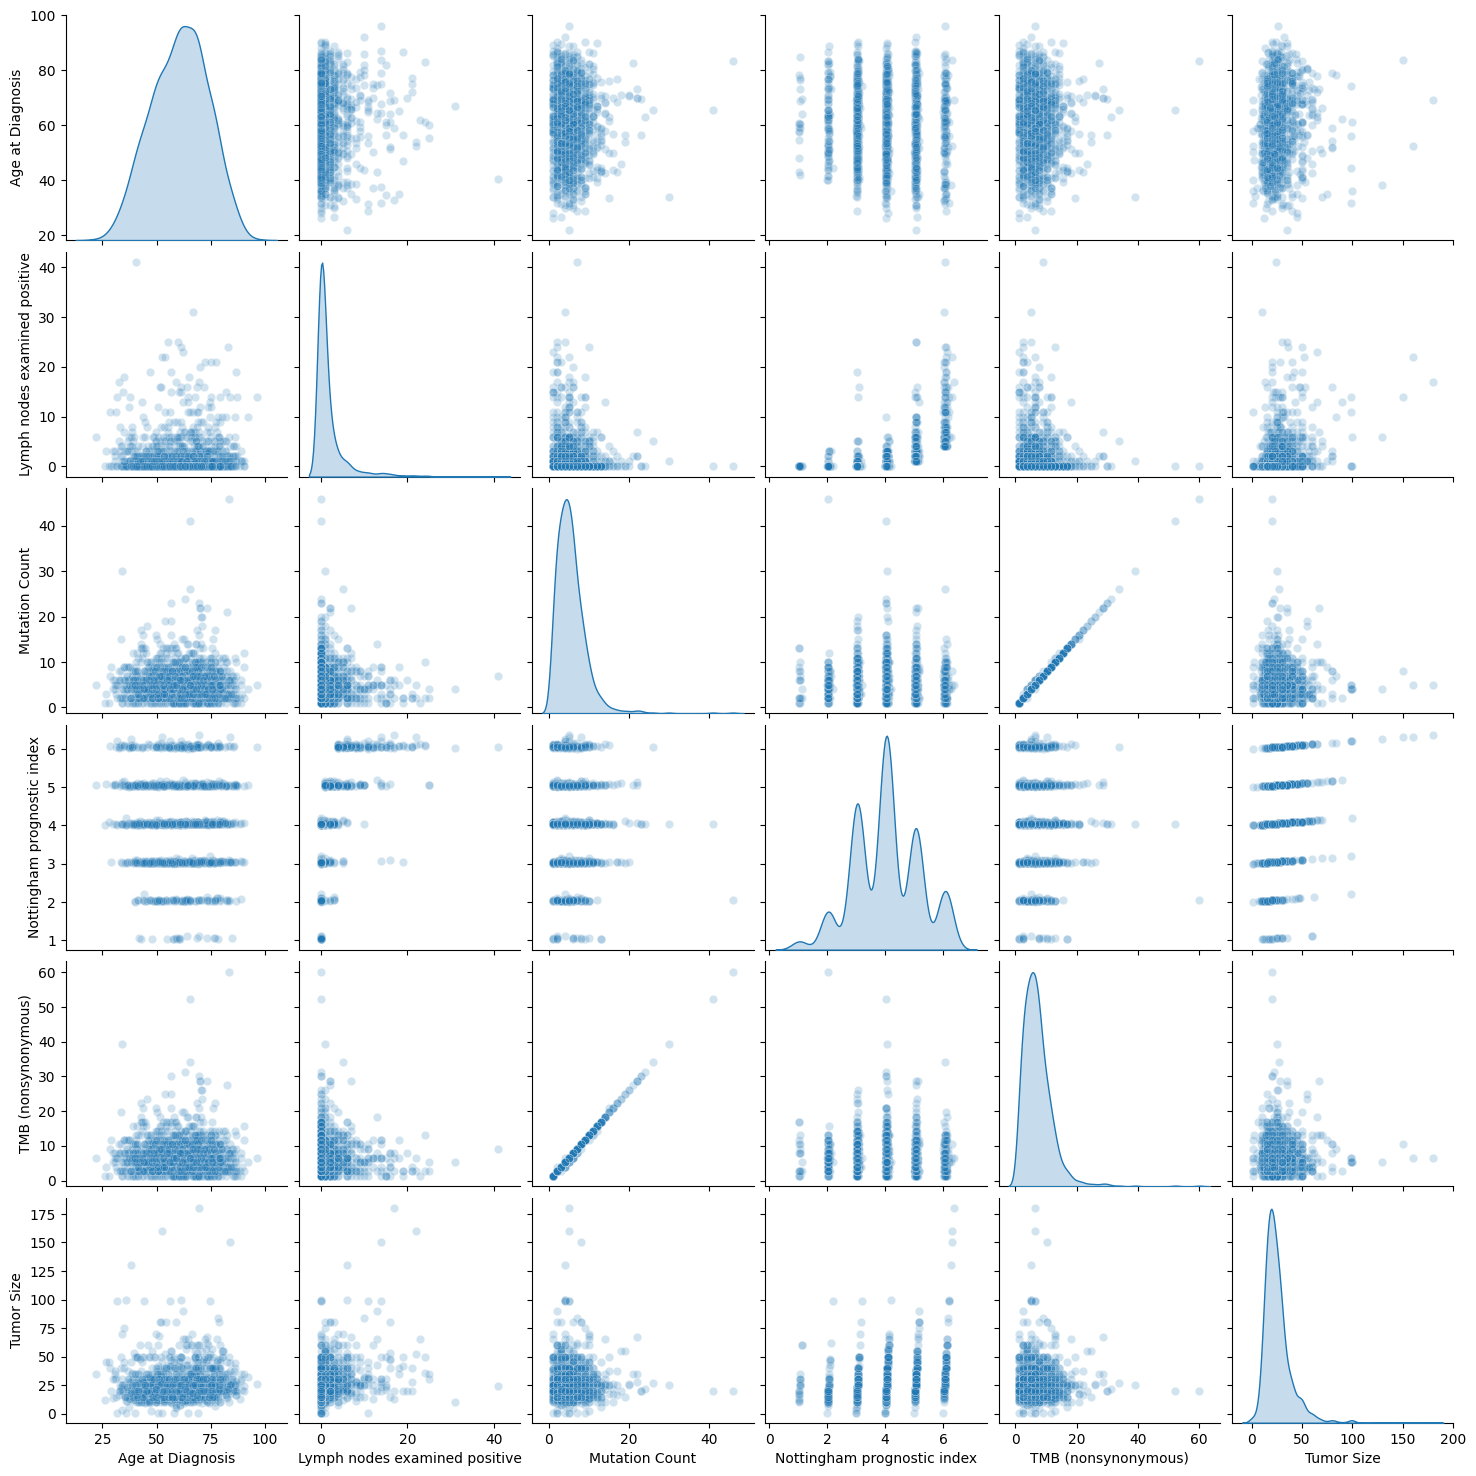

In [55]:
vars = ['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
       'Chemotherapy', 'Hormone Therapy', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index',
       'Overall Survival (Months)', 'Overall Survival Status', 'Radio Therapy',
       'TMB (nonsynonymous)', 'Tumor Size', 'Tumor Stage']

## Numeric variables

num_vars = ['Age at Diagnosis',
       'Lymph nodes examined positive',
       'Mutation Count',
       'Nottingham prognostic index',
       'TMB (nonsynonymous)',
       'Tumor Size',]

X_num = df.loc[ :, num_vars, ]
X_num.head()

sns.pairplot(data=X_num, diag_kind="kde", diag_kws={"fill": True}, plot_kws={"alpha": 0.2})

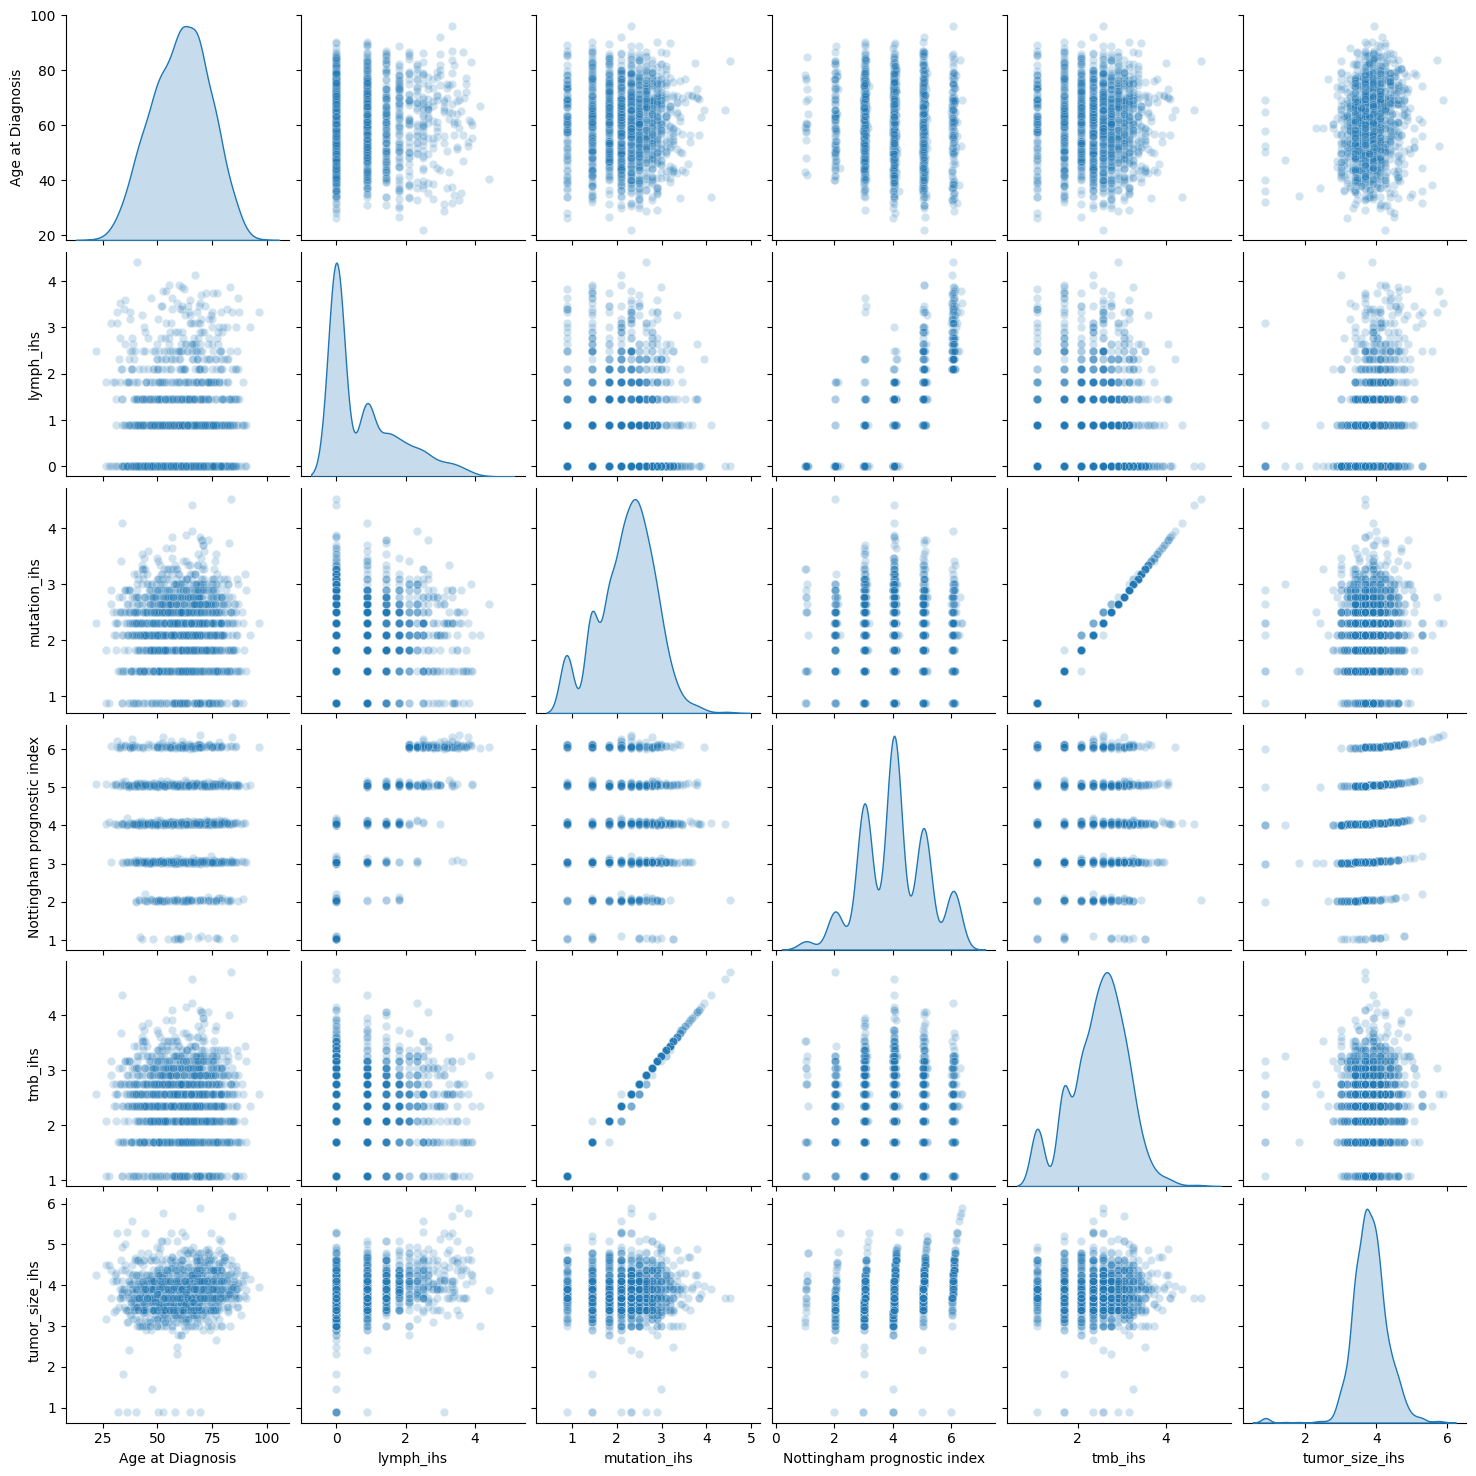

In [56]:
df['tumor_size_ihs'] = np.arcsinh(df['Tumor Size'])
df['tmb_ihs'] = np.arcsinh(df['TMB (nonsynonymous)'])
df['mutation_ihs'] = np.arcsinh(df['Mutation Count'])
df['lymph_ihs'] = np.arcsinh(df['Lymph nodes examined positive'])

num_vars = ['Age at Diagnosis',
       'lymph_ihs',
       'mutation_ihs',
       'Nottingham prognostic index',
       'tmb_ihs',
       'tumor_size_ihs',]

X_num = df.loc[ :, num_vars, ]
X_num.head()

sns.pairplot(data=X_num, diag_kind="kde", diag_kws={"fill": True}, plot_kws={"alpha": 0.2})


In [59]:
## Expand polynomial basis
expander = PolynomialFeatures(degree=2, include_bias = False, interaction_only=True)
X_poly = expander.fit_transform(X_num)
poly_names = expander.get_feature_names_out()
df_num = pd.DataFrame(X_poly, columns = poly_names )
df_num.head()

## Generate dummy variables
vars = ['Chemotherapy',
        'Hormone Therapy',
        'Radio Therapy',
        'Tumor Stage']

ohc_chemo = pd.get_dummies( df['Chemotherapy'], dtype = int, drop_first =True, prefix='chemo' )
ohc_hormone = pd.get_dummies( df['Hormone Therapy'], dtype = int, drop_first =True, prefix='hormone' )
ohc_radio = pd.get_dummies( df['Radio Therapy'], dtype = int, drop_first =True, prefix='radio' )
ohc_stage = pd.get_dummies( df['Tumor Stage'], dtype = int, drop_first =True, prefix='stage' )

#ohc_stage.head()

## Combine controls/features:
X = pd.concat([df_num, ohc_chemo, ohc_hormone, ohc_radio, ohc_stage], axis=1)
X.head()

,Age at Diagnosis,lymph_ihs,mutation_ihs,Nottingham prognostic index,tmb_ihs,tumor_size_ihs,Age at Diagnosis lymph_ihs,Age at Diagnosis mutation_ihs,Age at Diagnosis Nottingham prognostic index,Age at Diagnosis tmb_ihs,...,Nottingham prognostic index tmb_ihs,Nottingham prognostic index tumor_size_ihs,tmb_ihs tumor_size_ihs,chemo_YES,hormone_YES,radio_YES,stage_1.0,stage_2.0,stage_3.0,stage_4.0
0,43.19,0.000000,1.443635,4.020,1.689127,2.998223,0.000000,62.350616,173.62380,72.953395,...,6.790290,12.052856,5.064379,0,1,1,1,0,0,0
1,48.87,0.881374,1.443635,4.030,1.689127,3.402307,43.072727,70.550466,196.94610,82.547636,...,6.807182,13.711296,5.746928,1,1,0,0,1,0,0
2,47.68,1.818446,0.881374,4.050,1.083026,3.912423,86.703527,42.023893,193.10400,51.638697,...,4.386257,15.845312,4.237257,1,1,1,0,1,0,0
3,76.97,2.776472,1.443635,6.080,1.689127,4.382183,213.705071,111.116623,467.97760,130.012104,...,10.269892,26.643672,7.402063,1,1,1,0,1,0,0
4,78.77,0.000000,2.094713,4.062,2.356589,4.127394,0.000000,165.000507,319.96374,185.628495,...,9.572463,16.765476,9.726571,0,1,1,0,0,0,1


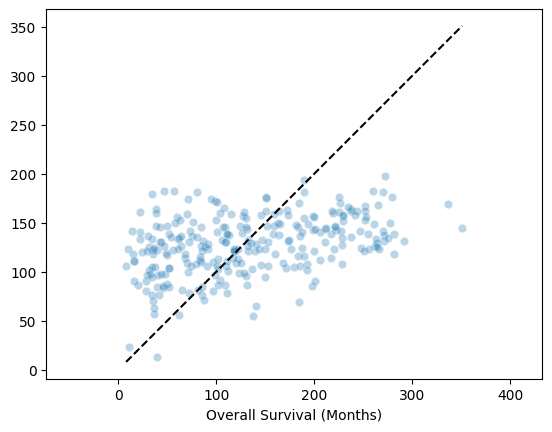

Mean squared error:  5288.0146841273445
Root mean squared error:  72.71873681608712


In [63]:
## Linear regression and fit

X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

model = LinearRegression()
model = model.fit(X_train, y_train)
y_hat = model.predict(X_test)

sns.scatterplot(x=y_test,y=y_hat,alpha=.3)
lims = [
    min(min(y_test), min(y_hat)),
    max(max(y_test), max(y_hat))]
plt.plot(lims, lims, "--k")
plt.xlim(lims)
plt.ylim(lims)
plt.axis("equal")

plt.show()

print(f'Mean squared error: ', mse(y_test, y_hat))
print(f'Root mean squared error: ', np.sqrt(mse(y_test, y_hat)) )
